# March Machine Learning Mania 2017

## Season 分析



In [1]:
import csv
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

### 读取数据

先读取RegularSeasonCompactResults、Teams两份数据，做最基本的分析。RegularSeasonCompactResults的数据是从1985年开始的。

In [2]:
# 读取RegularSeasonCompactResults
df_rscr = pd.read_csv('data/RegularSeasonCompactResults.csv')
df_rscr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [4]:
# 读取Teams
df_teams = pd.read_csv('data/Teams.csv')
df_teams.head()

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


### 主客场胜率

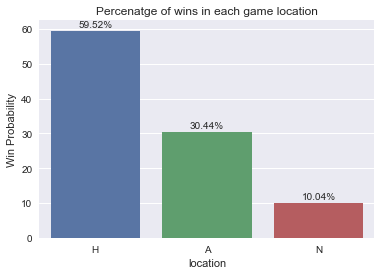

In [161]:
# 取Wolc列，并计数，并转为DataFrame，并求百分率
df_wloc = df_rscr['Wloc'].value_counts().reset_index().apply(lambda x: 100.0 * x / x.sum() if x.name != 'index' else x)

# 绘制bar plot
ax = sns.barplot(x='index', y='Wloc', data=df_wloc)
# 在图上写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1, '{:1.2f}%'.format(height), ha="center") 
# 标题、坐标的label
ax.set(xlabel='location', ylabel='Win Probability', title='Percenatge of wins in each game location')
plt.show()

### 加时情况

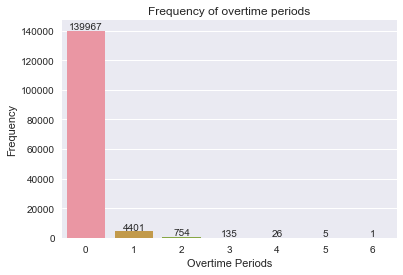

In [159]:
# 取 Numot 列，并计数
se_num_ot = df_rscr['Numot'].value_counts()

# 绘制bar plot
ax = sns.barplot(list(se_num_ot.axes[0]), se_num_ot.values)
# 写具体的值
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1000, '{:1.0f}'.format(height), ha="center") 
# 标题
ax.set(xlabel='Overtime Periods', ylabel='Frequency', title='Frequency of overtime periods')
plt.show()

### Win percentage for all teams

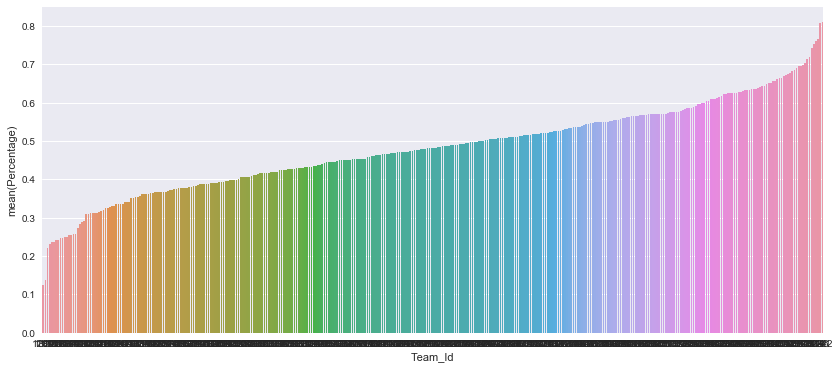

In [195]:
#分别统计每个球队的胜负场次，然后合并
df_win_per = pd.merge(
    df_rscr['Wteam'].value_counts().reset_index(),
    df_rscr['Lteam'].value_counts().reset_index(),
    on='index')
df_win_per.columns = ['Team_Id', 'Win', 'Loss']
# 计算胜率
df_win_per['Percentage'] = df_win_per['Win'] / (df_win_per['Win'] + df_win_per['Loss'])
# 球队名字
df_win_per = pd.merge(df_win_per, df_teams, on='Team_Id').sort_values('Percentage')

# 绘图
plt.subplots(figsize=(14, 6))
sns.barplot(x='Team_Id', y='Percentage', data=df_win_per, order=list(df_win_per['Team_Id']))
plt.show()

"What are the top 30 teams? "

In [196]:
# 胜率最好的30支球队
df_top_30 = df_win_per.tail(30)[::-1]

# 显示前15支 
df_top_30.head(15)

,Team_Id,Win,Loss,Percentage,Team_Name
1,1242,804,189,0.809668,Kansas
0,1181,819,194,0.808490,Duke
2,1246,765,234,0.765766,Kentucky
4,1112,746,235,0.760449,Arizona
3,1314,761,249,0.753465,North Carolina
5,1393,738,255,0.743202,Syracuse
13,1211,663,258,0.719870,Gonzaga
9,1462,681,273,0.713836,Xavier
7,1424,685,289,0.703285,UNLV
6,1272,692,300,0.697581,Memphis


"What are the worst 30 teams? "

In [197]:
# 胜率最差的30支球队
df_worst_30 = df_win_per.head(30)

# 显示前15支 
df_worst_30.head(15)

,Team_Id,Win,Loss,Percentage,Team_Name
362,1289,6,42,0.125000,Morris Brown
363,1327,3,19,0.136364,Okla City
361,1118,6,21,0.222222,Armstrong St
346,1146,62,205,0.232210,Cent Arkansas
359,1101,18,58,0.236842,Abilene Chr
311,1152,205,660,0.236994,Chicago St
340,1255,83,261,0.241279,Longwood
358,1445,26,81,0.242991,W Salem St
348,1188,51,156,0.246377,Edwardsville
308,1341,212,645,0.247375,Prairie View


### Average points scored for each team

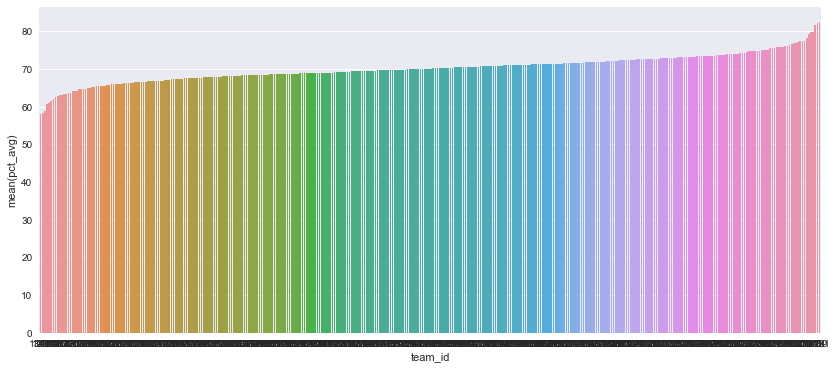

In [10]:
# 获取每个球队胜利的平均分、总分、场次
grp_win = df_rscr.groupby('Wteam')['Wscore']
win_score_mean = grp_win.mean()
win_score_sum = grp_win.sum()
win_count = grp_win.count()

# 获取每个球队失败的平均分、总分、场次
grp_loss = df_rscr.groupby('Lteam')['Lscore']
loss_score_mean = grp_loss.mean()
loss_score_sum = grp_loss.sum()
loss_count = grp_loss.count()

# 计算所以场次的平均分
df_points = pd.DataFrame(
    index=np.array(teams_id),
    columns=['team_id', 'team_name', 'pct_avg', 'pct_count', 'win_avg', 'win_count', 'loss_avg', 'loss_count'])
for team_id in teams_id:
    df_points.loc[team_id]['team_id'] = team_id
    df_points.loc[team_id]['team_name'] = df_teams.loc[df_teams['Team_Id'] == team_id].iloc[0]['Team_Name']
    df_points.loc[team_id]['win_avg'] = win_score_mean.loc[team_id]
    df_points.loc[team_id]['win_count'] = win_count.loc[team_id]
    df_points.loc[team_id]['loss_avg'] = loss_score_mean.loc[team_id]
    df_points.loc[team_id]['loss_count'] = loss_count.loc[team_id]
    df_points.loc[team_id]['pct_count'] = win_count.loc[team_id] + loss_count.loc[team_id]
    df_points.loc[team_id]['pct_avg'] = (loss_score_sum.loc[team_id] + win_score_sum.loc[team_id]) / (win_count.loc[team_id] + loss_count.loc[team_id])

# 排序
df_points = df_points.sort_values('pct_avg')

# 绘图
plt.subplots(figsize=(14, 6))
sns.barplot(x='team_id', y='pct_avg', data=df_points, order=list(df_points['pct_avg'].axes[0]))
plt.show()

In [209]:
rs = df_rscr.groupby('Wteam')['Wscore'].apply(lambda x: [x.name, x.sum(), x.count()])
rs

Wteam
1101      [1101, 1406, 18]
1102    [1102, 21597, 309]
1103    [1103, 39285, 518]
1104    [1104, 46178, 609]
1105    [1105, 13418, 179]
1106    [1106, 30194, 394]
1107    [1107, 17772, 251]
1108    [1108, 23529, 296]
1109      [1109, 3798, 42]
1110    [1110, 30516, 423]
1111    [1111, 31988, 411]
1112    [1112, 61336, 746]
1113    [1113, 37327, 479]
1114    [1114, 38086, 501]
1115    [1115, 10069, 147]
1116    [1116, 52826, 625]
1117    [1117, 32746, 439]
1118        [1118, 399, 6]
1119    [1119, 20486, 283]
1120    [1120, 36969, 473]
1121      [1121, 3602, 48]
1122    [1122, 34076, 437]
1123    [1123, 35566, 477]
1124    [1124, 36035, 458]
1125    [1125, 25719, 321]
1126    [1126, 21963, 303]
1127    [1127, 10843, 157]
1128      [1128, 4827, 67]
1129    [1129, 38997, 522]
1130    [1130, 38264, 492]
               ...        
1435    [1435, 44260, 561]
1436    [1436, 36195, 483]
1437    [1437, 48661, 629]
1438    [1438, 43026, 568]
1439    [1439, 36868, 480]
1440    [1440, 22818, 

"What are the top 30 teams? "

In [11]:
df_points_top_30 = df_points[::-1].head(30)

df_points_top_30.head(15)

,team_id,team_name,pct_avg,pct_count,win_avg,win_count,loss_avg,loss_count
1181,1181,Duke,82.3939,1013,84.6252,819,72.9742,194
1109,1109,Alliant Intl,82.2426,169,90.4286,42,79.5354,127
1314,1314,North Carolina,81.6208,1010,84.8988,761,71.6024,249
1242,1242,Kansas,79.8731,993,82.5261,804,68.5873,189
1328,1328,Oklahoma,79.7603,968,84.636,673,68.6373,295
1112,1112,Arizona,79.3058,981,82.2198,746,70.0553,235
1116,1116,Arkansas,78.2541,980,84.5216,625,67.2197,355
1246,1246,Kentucky,77.4014,999,80.0706,765,68.6752,234
1424,1424,UNLV,77.3398,974,81.4102,685,67.692,289
1400,1400,Texas,77.2709,982,80.8742,652,70.1515,330


"What are the worst 30 teams? "

In [12]:
df_points_worst_30 = df_points.head(30)

df_points_worst_30.head(15)

,team_id,team_name,pct_avg,pct_count,win_avg,win_count,loss_avg,loss_count
1366,1366,Savannah St,57.8958,384,64.3167,120,54.9773,264
1289,1289,Morris Brown,58.3542,48,71.5,6,56.4762,42
1445,1445,W Salem St,58.7383,107,69.2308,26,55.3704,81
1115,1115,Ark Pine Bluff,60.6308,520,68.4966,147,57.5308,373
1342,1342,Presbyterian,60.9731,260,69.3881,67,58.0518,193
1343,1343,Princeton,61.5421,832,66.0095,527,53.823,305
1127,1127,Binghamton,61.9321,442,69.0637,157,58.0035,285
1446,1446,W Texas A&M,62.4792,48,68.2857,14,60.0882,34
1162,1162,Columbia,62.9218,831,69.8949,314,58.6867,517
1415,1415,UC Riverside,62.9785,418,70.7348,132,59.3986,286


### How does the number of points scored correlate to the game result?

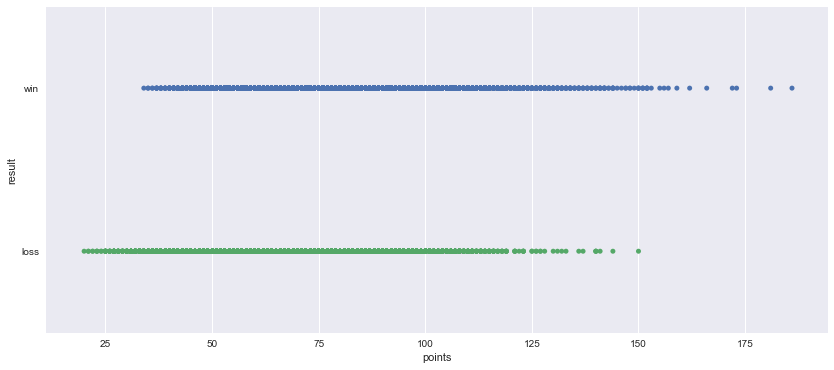

In [13]:
win_points = list(df_rscr['Wscore'].values)
loss_points = list(df_rscr['Lscore'].values)

# 构建 得分-结果 关系
df_points_result = pd.DataFrame(index=np.array(range(len(win_points) + len(loss_points))), columns=['points', 'result'])
df_points_result['points'] = win_points + loss_points
df_points_result['result'] = ['win'] * len(win_points) + ['loss'] * len(loss_points)
df_points_result

# 绘图
plt.subplots(figsize=(14, 6))
ax = sns.stripplot(x="points", y="result", data=df_points_result)
plt.show()

### Win probability across features

看看各个特征与胜率的关系。需要读取RegularSeasonDetailedResults数据

In [114]:
# 读取RegularSeasonDetailedResults
df_rsdr = pd.read_csv('data/RegularSeasonDetailedResults.csv')
df_rsdr.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


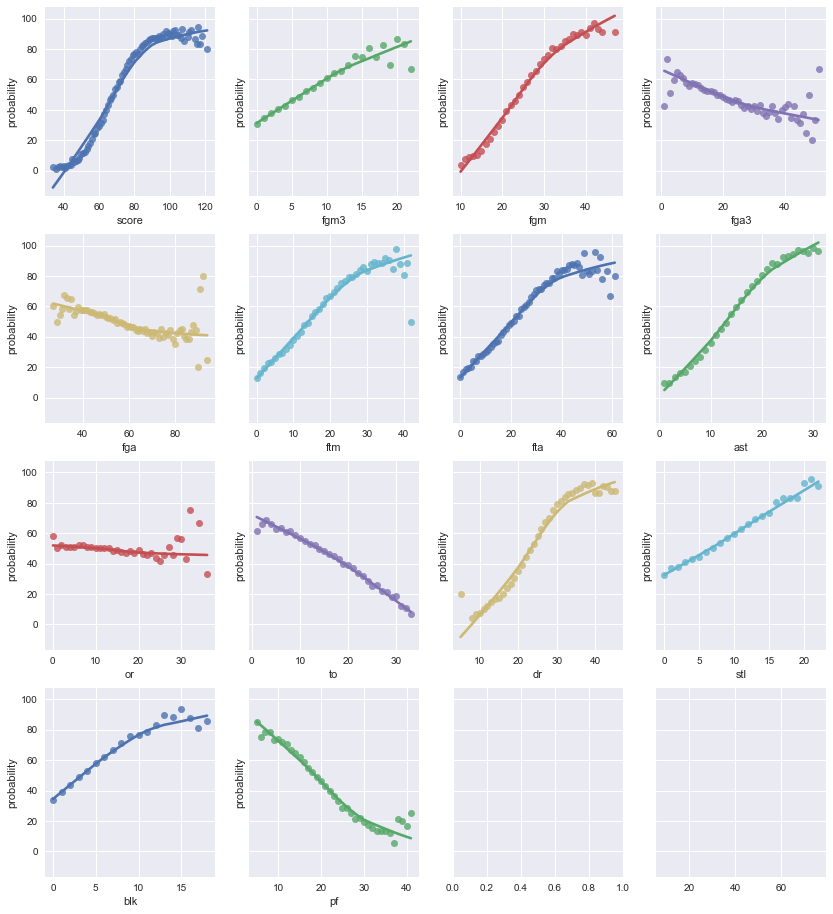

In [113]:
def cal_probability(_name):
    """ 计算特征与胜率的关系
    """
    df1 = df_rsdr['W%s' % _name].value_counts().reset_index()
    df1.columns = [_name, 'win_num']

    df2 = df_rsdr['L%s' % _name].value_counts().reset_index()
    df2.columns = [_name, 'loss_num']

    df = pd.merge(df1, df2, on=_name)
    df['probability'] = 100.0 * df['win_num'] / (df['win_num'] + df['loss_num'])
    
    return df

# 要看的特征
names = ['score', 'fgm3', 'fgm', 'fga3', 'fga', 'ftm', 'fta', 'ast', 'or', 'to', 'dr', 'stl', 'blk', 'pf']

# 计算特征与胜率的关系，并绘图
fig, ax = plt.subplots(4, 4, figsize=(14, 16), sharey=True)
i = 0
for n in names:
    df = cal_probability(n)
    sns.regplot(x=n, y="probability", data=df, lowess=True, ax=ax[int(i / 4)][i % 4])
    i += 1
plt.show()